In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import tqdm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [3]:
np.random.seed(0)

In [4]:
CENSUS_GPS_IN_DIR = 'data/GiveDirectly/Survey/GE_HH_Census_2017-07-17_cleanGPS.csv'
CENSUS_MASTER_IN_DIR = 'data/GiveDirectly/Survey/GE_HH-Census_Analysis_RA_2017-07-17.dta'
SAT_IN_GEOM_DIR = 'data/Experiment4/sat.geojson'

OUT_DIR = 'data/Experiment4/output/'

In [5]:
min_lon = 34.040  # 34.044261
max_lon = 34.460  # 34.451611
min_lat = -0.055  # -0.050481
max_lat = 0.315  # 0.310766
step = 0.001  # degrees

## Satellite

In [6]:
df = gpd.read_file(SAT_IN_GEOM_DIR)
# score threshold
df = df.loc[df['score'] > 0.9, :].copy()
# extract centroid
df.loc[:, 'centroid_lon'] = df.geometry.centroid.x.values
df.loc[:, 'centroid_lat'] = df.geometry.centroid.y.values

In [7]:
# snap to grid
df.loc[:, 'grid_lon'] = np.round((df['centroid_lon'].values - min_lon) / step).astype(np.int32)
df.loc[:, 'grid_lat'] = np.round((df['centroid_lat'].values - min_lat) / step).astype(np.int32)

In [8]:
# roof color, view histogram and scatter
# df['R_mean'].plot(kind='hist', bins=50)
# pd.DataFrame(df).plot.scatter(x='R_mean', y='B_mean', alpha=0.1)
svm_coef = np.array([[-0.06021201, 0.0905571, 0.00755191]])
luma_coef = np.array([[0.3, 0.59, 0.11]])
svm_intercept = -6.17484352

df.loc[:, 'RGB_mean'] = np.mean(df.loc[:, ['R_mean', 'G_mean', 'B_mean']].values, axis=1)
df.loc[:, 'RGB_max'] = np.max(df.loc[:, ['R_mean', 'G_mean', 'B_mean']].values, axis=1)
df.loc[:, 'RGB_min'] = np.min(df.loc[:, ['R_mean', 'G_mean', 'B_mean']].values, axis=1)
df.loc[:, 'RGB_svm'] = df.loc[:, ['R_mean', 'G_mean', 'B_mean']].values.dot(svm_coef.T) + svm_intercept
df.loc[:, 'RGB_svm_metal'] = df.loc[:, 'RGB_svm'].values > 0
df.loc[:, 'RGB_maxminhalf'] = (df.loc[:, 'RGB_max'].values + df.loc[:, 'RGB_min'].values) / 2
df.loc[:, 'RGB_luma'] = df.loc[:, ['R_mean', 'G_mean', 'B_mean']].values.dot(luma_coef.T)

In [9]:
# collapse to grid
df_outcome = df.groupby(['grid_lon', 'grid_lat']).agg(
    house_count=pd.NamedAgg(column='area', aggfunc='count'),
    area_sum=pd.NamedAgg(column='area', aggfunc='sum'),
    RGB_mean=pd.NamedAgg(column='RGB_mean', aggfunc='mean'),
    RGB_max=pd.NamedAgg(column='RGB_max', aggfunc='mean'),
    RGB_min=pd.NamedAgg(column='RGB_min', aggfunc='mean'),
    RGB_svm=pd.NamedAgg(column='RGB_svm', aggfunc='mean'),
    RGB_svm_metal=pd.NamedAgg(column='RGB_svm_metal', aggfunc='mean'),
    RGB_maxminhalf=pd.NamedAgg(column='RGB_maxminhalf', aggfunc='mean'),
    RGB_luma=pd.NamedAgg(column='RGB_luma', aggfunc='mean'),
    saturation=pd.NamedAgg(column='saturation', aggfunc='mean'),
)

In [10]:
# convert unit
df_outcome.loc[:, 'area_sum'] *= ((0.001716 * 111000 / 800) ** 2)  # in sq meters
df_outcome.loc[:, 'area_sum_pct'] = df_outcome['area_sum'].values / ((step * 111000) ** 2)

## Treatment

In [11]:
# read GPS coords + treatment status
df = pd.read_csv(
    CENSUS_GPS_IN_DIR,
    usecols=['village_code', 'ge', 'hi_sat', 'treat',
             'latitude', 'longitude', 'elevation', 'accuracy', 'eligible',
             'GPS_imputed'],
    dtype={
        'sublocation_code': 'Int64',
        'village_code': 'Int64',
        'ge': 'Int32',
        'hi_sat': 'Int32',
        'treat': 'Int32',
        'eligible': 'Int32',
        'GPS_imputed': 'Int32'})
# drop non GE households
df = df.loc[df['ge'] == 1, :]
# snap to grid
df.loc[:, 'grid_lon'] = np.round((df['longitude'].values - min_lon) / step).astype(np.int32)
df.loc[:, 'grid_lat'] = np.round((df['latitude'].values - min_lat) / step).astype(np.int32)
# read sat level identifiers
df_randomization = pd.read_stata(
    CENSUS_MASTER_IN_DIR,
    columns=['village_code', 'satlevel_name'])
df_randomization = df_randomization.drop_duplicates().astype({'village_code': 'Int64'})
satgrps = df_randomization['satlevel_name'].unique().tolist()
# merge treatment
df_treat = pd.merge(df, df_randomization,
                    on='village_code', how='left')
# coords, for placebo sample
df_coords = df_treat.loc[:, [
    'satlevel_name', 'village_code', 'latitude', 'longitude',
    'eligible', 'grid_lon', 'grid_lat']].copy()
# for merging with outcome rasters
df_mask = df_coords.groupby(['grid_lon', 'grid_lat']).agg(
    eligible=pd.NamedAgg(column='eligible', aggfunc='sum'),
)
df_mask = df_mask.loc[df_mask['eligible'] != 0, :]
df_mask.to_csv(os.path.join(OUT_DIR, 'eligible_grids.csv'))

## Graph

In [17]:
# main graph
bins = [-1, 0, 1, 2, 3, 40]
labels = ["$0", "$1000", "$2000", "$3000", ">$3000"]
col_x = 'treat_eligible'
col_y = 'RGB_mean'
N_simu = 200

In [18]:
df_placebo_plot = []

### PLACEBO ###
for i_simu in tqdm.tqdm_notebook(range(N_simu)):
    # draw saturation level
    df_draw = pd.merge(
        pd.DataFrame({
            'hi_sat': np.random.random(len(satgrps)),
            'satlevel_name': satgrps}),
        df_randomization,
        how='outer',
        on='satlevel_name')
    df_draw.loc[:, 'hi_sat'] = df_draw.loc[:, 'hi_sat'] > 0.5
    # draw treatment status
    df_draw.loc[:, 'treat'] = np.random.random(df_draw.shape[0])
    df_draw.loc[:, 'treat'] = df_draw.apply(
        lambda x: x['treat'] > (0.33 if x['hi_sat'] else 0.67),
        axis=1)
    # merge with eligible counts
    df_placebo = pd.merge(
        df_draw.loc[:, ['village_code', 'treat']].astype({'treat': 'int'}),
        df_coords,
        how='right',
        on='village_code')
    # create treat x eligible
    df_placebo.loc[:, 'treat_eligible'] = df_placebo['treat'].values * df_placebo['eligible'].values
    # collapse to grid
    df_placebo = df_placebo.groupby(['grid_lon', 'grid_lat']).agg(
        n_household=pd.NamedAgg(column='eligible', aggfunc='count'),
        eligible=pd.NamedAgg(column='eligible', aggfunc='sum'),
        treat_eligible=pd.NamedAgg(column='treat_eligible', aggfunc='sum'),
    )
    # drop grids with 0 eligibles
    df_placebo = df_placebo.loc[df_placebo['eligible'] != 0, :]
    # normalize with n_household
    df_placebo.loc[:, 'treat_eligible_pct'] = (
        df_placebo['treat_eligible'].values / df_placebo['n_household'].values)
    # normalize with n_eligible
    df_placebo.loc[:, 'treat_pct'] = df_placebo['treat_eligible'].values / df_placebo['eligible'].values
    # merge with outcomes
    df_placebo = pd.merge(df_placebo, df_outcome, how='left', on=['grid_lon', 'grid_lat'])
    df_placebo = df_placebo.astype({'eligible': np.float64, 'treat_eligible': np.float64})
    # fill NAs
    df_placebo.fillna(value={'house_count': 0, 'area_sum': 0}, inplace=True)
    df_placebo.loc[:, 'house_count_0'] = (df_placebo['house_count'] == 0).values.astype(np.float)
    # compute per capita
    df_placebo.loc[:, 'area_sum_ph'] = df_placebo['area_sum'].values / df_placebo['n_household'].values
    # cut into bins
    df_placebo.loc[:, 'bin'] = pd.cut(
        df_placebo[col_x],
        bins=bins, include_lowest=True)
    mod = smf.ols(formula=col_y + ' ~ C(bin)', data=df_placebo)
    res = mod.fit()
    betas = res.params.values
    betas[0] = 0
    df_placebo_plot.append(pd.DataFrame({col_y: res.params.values, 'bin': labels, 'i': i_simu}))

df_placebo_plot = pd.concat(df_placebo_plot)

In [19]:
### ACTUAL EFFECTS ###
# create treat x eligible
df_treat.loc[:, 'treat_eligible'] = df_treat.loc[:, 'treat'].values * df_treat.loc[:, 'eligible'].values
# collapse to grid
df = df_treat.groupby(['grid_lon', 'grid_lat']).agg(
    n_household=pd.NamedAgg(column='eligible', aggfunc='count'),
    eligible=pd.NamedAgg(column='eligible', aggfunc='sum'),
    treat_eligible=pd.NamedAgg(column='treat_eligible', aggfunc='sum'),
)
# drop grids with 0 eligibles
df = df.loc[df['eligible'] != 0, :]
# normalize with n_household
df.loc[:, 'treat_eligible_pct'] = df['treat_eligible'].values / df['n_household'].values
# normalize with n_eligible
df.loc[:, 'treat_pct'] = df['treat_eligible'].values / df['eligible'].values
# merge with outcomes
df = pd.merge(df, df_outcome, how='left', on=['grid_lon', 'grid_lat'])
df = df.astype({'eligible': np.float64, 'treat_eligible': np.float64})
# fill NAs
df.fillna(value={'house_count': 0, 'area_sum': 0}, inplace=True)
df.loc[:, 'house_count_0'] = (df['house_count'] == 0).values.astype(np.float)
# compute per capita
df.loc[:, 'area_sum_ph'] = df['area_sum'].values / df['n_household'].values
# cut into bins
df.loc[:, 'bin'] = pd.cut(
    df[col_x],
    bins=bins, include_lowest=True)
mod = smf.ols(formula=col_y + ' ~ C(bin)', data=df.dropna(subset=[col_y]))
res = mod.fit()
betas = res.params.values
control_sd = df.loc[df['treat_eligible'] == 0, col_y].dropna().values.std()
betas[0] = 0
df_actual_plot = pd.DataFrame({col_y: res.params.values, 'bin': labels})

In [20]:
# scaling with control SD units
df_actual_plot.loc[:, col_y] = df_actual_plot[col_y].values / control_sd
df_placebo_plot.loc[:, col_y] = df_placebo_plot[col_y].values / control_sd
# normalize with placebo mean
placebo_means = df_placebo_plot.loc[:, [col_y, 'bin']].groupby('bin').agg(
    placebo_mean=pd.NamedAgg(column=col_y, aggfunc='mean'),
).reset_index()
df_placebo_plot = pd.merge(df_placebo_plot, placebo_means, how='left', on='bin')
df_actual_plot = pd.merge(df_actual_plot, placebo_means, how='left', on='bin')
df_placebo_plot.loc[:, col_y] = df_placebo_plot[col_y].values - df_placebo_plot['placebo_mean'].values
df_actual_plot.loc[:, col_y] = df_actual_plot[col_y].values - df_actual_plot['placebo_mean'].values

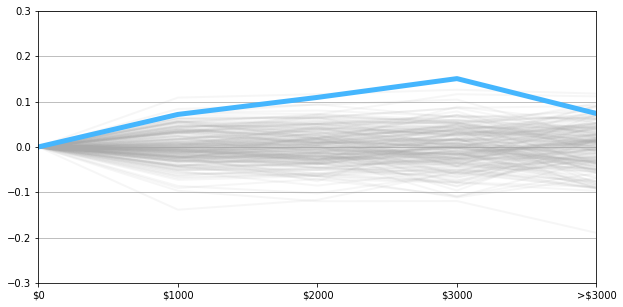

In [21]:
# plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=df_placebo_plot, x='bin', y=col_y, units='i', estimator=None,
             ax=ax, color='#aaaaaa', linewidth=2, alpha=0.1, legend=None)
df_actual_plot.plot(x='bin', y=col_y, ax=ax,
                    color='#45b6fe', linewidth=5, legend=None)
ax.grid(axis='y')
ax.set_ylim(-0.3, 0.3)
ax.set_yticks([-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3])
ax.set_xlabel('')
ax.set_ylabel('')
fig.savefig(os.path.join(OUT_DIR, col_y + '_te.pdf'))

In [17]:
df.groupby('bin').count()

,n_household,eligible,treat_eligible,treat_eligible_pct,treat_pct,house_count,area_sum,RGB_mean,RGB_max,RGB_min,RGB_svm,RGB_svm_metal,RGB_maxminhalf,RGB_luma,saturation,area_sum_pct,house_count_0,area_sum_ph
bin,,,,,,,,,,,,,,,,,,
"(-1.001, 0.0]",6995,6995,6995,6995,6995,6995,6995,6091,6091,6091,6091,6091,6091,6091,6091,6091,6995,6995
"(0.0, 1.0]",4684,4684,4684,4684,4684,4684,4684,4109,4109,4109,4109,4109,4109,4109,4109,4109,4684,4684
"(1.0, 2.0]",1640,1640,1640,1640,1640,1640,1640,1535,1535,1535,1535,1535,1535,1535,1535,1535,1640,1640
"(2.0, 3.0]",543,543,543,543,543,543,543,517,517,517,517,517,517,517,517,517,543,543
"(3.0, 40.0]",317,317,317,317,317,317,317,308,308,308,308,308,308,308,308,308,317,317


In [18]:
df_placebo.groupby('bin').count()

,n_household,eligible,treat_eligible,treat_eligible_pct,treat_pct,house_count,area_sum,RGB_mean,RGB_max,RGB_min,RGB_svm,RGB_svm_metal,RGB_maxminhalf,RGB_luma,saturation,area_sum_pct,house_count_0,area_sum_ph
bin,,,,,,,,,,,,,,,,,,
"(-1.001, 0.0]",7612,7612,7612,7612,7612,7612,7612,6685,6685,6685,6685,6685,6685,6685,6685,6685,7612,7612
"(0.0, 1.0]",4311,4311,4311,4311,4311,4311,4311,3770,3770,3770,3770,3770,3770,3770,3770,3770,4311,4311
"(1.0, 2.0]",1441,1441,1441,1441,1441,1441,1441,1325,1325,1325,1325,1325,1325,1325,1325,1325,1441,1441
"(2.0, 3.0]",516,516,516,516,516,516,516,489,489,489,489,489,489,489,489,489,516,516
"(3.0, 40.0]",299,299,299,299,299,299,299,291,291,291,291,291,291,291,291,291,299,299


## Regressions

In [19]:
mod = smf.ols(formula='area_sum ~ treat_pct', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               area_sum   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     55.16
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           1.18e-13
Time:                        00:30:20   Log-Likelihood:                -92964.
No. Observations:               14179   AIC:                         1.859e+05
Df Residuals:                   14177   BIC:                         1.859e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    179.6711      2.032     88.433      0.0

In [20]:
mod = smf.ols(formula='house_count_0 ~ treat_pct', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          house_count_0   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     29.00
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           7.37e-08
Time:                        00:30:20   Log-Likelihood:                -3861.2
No. Observations:               14179   AIC:                             7726.
Df Residuals:                   14177   BIC:                             7742.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1287      0.004     33.947      0.0

In [21]:
mod = smf.ols(formula='RGB_mean ~ treat_pct', data=df.dropna())
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               RGB_mean   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     24.92
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           6.04e-07
Time:                        00:30:20   Log-Likelihood:                -59468.
No. Observations:               12560   AIC:                         1.189e+05
Df Residuals:                   12558   BIC:                         1.190e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    161.9361      0.352    459.920      0.0

In [22]:
mod = smf.ols(formula='RGB_max ~ treat_pct', data=df.dropna())
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                RGB_max   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     18.61
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           1.62e-05
Time:                        00:30:20   Log-Likelihood:                -57994.
No. Observations:               12560   AIC:                         1.160e+05
Df Residuals:                   12558   BIC:                         1.160e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    171.6649      0.313    548.258      0.0

In [23]:
mod = smf.ols(formula='RGB_min ~ treat_pct', data=df.dropna())
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                RGB_min   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     22.96
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           1.67e-06
Time:                        00:30:20   Log-Likelihood:                -60649.
No. Observations:               12560   AIC:                         1.213e+05
Df Residuals:                   12558   BIC:                         1.213e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    152.0221      0.387    393.023      0.0

In [24]:
mod = smf.ols(formula='RGB_svm ~ treat_pct', data=df.dropna())
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                RGB_svm   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     50.18
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           1.48e-12
Time:                        00:30:21   Log-Likelihood:                -24711.
No. Observations:               12560   AIC:                         4.943e+04
Df Residuals:                   12558   BIC:                         4.944e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1177      0.022      5.320      0.0

In [25]:
mod = smf.ols(formula='RGB_svm_metal ~ treat_pct', data=df.dropna())
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          RGB_svm_metal   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     38.21
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           6.55e-10
Time:                        00:30:21   Log-Likelihood:                -3870.7
No. Observations:               12560   AIC:                             7745.
Df Residuals:                   12558   BIC:                             7760.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6703      0.004    159.232      0.0

In [26]:
mod = smf.ols(formula='RGB_maxminhalf ~ treat_pct', data=df.dropna())
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         RGB_maxminhalf   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     21.76
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           3.12e-06
Time:                        00:30:21   Log-Likelihood:                -59154.
No. Observations:               12560   AIC:                         1.183e+05
Df Residuals:                   12558   BIC:                         1.183e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    161.8435      0.343    471.281      0.0

In [27]:
mod = smf.ols(formula='RGB_luma ~ treat_pct', data=df.dropna())
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               RGB_luma   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     24.79
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           6.47e-07
Time:                        00:30:21   Log-Likelihood:                -59590.
No. Observations:               12560   AIC:                         1.192e+05
Df Residuals:                   12558   BIC:                         1.192e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    162.4479      0.356    456.903      0.0

In [28]:
mod = smf.ols(formula='saturation ~ treat_pct', data=df.dropna())
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             saturation   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.453
Date:                Tue, 03 Mar 2020   Prob (F-statistic):              0.117
Time:                        00:30:21   Log-Likelihood:                 11021.
No. Observations:               12560   AIC:                        -2.204e+04
Df Residuals:                   12558   BIC:                        -2.202e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1630      0.001    126.718      0.0

In [29]:
col_x = 'treat_pct'
col_y = 'area_sum_pct'
quantiles = np.linspace(.05, .95, 10)
def fit_model(q):
    mod = smf.quantreg(col_y + ' ~ ' + col_x, data=df)
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params[col_x]] + res.conf_int().loc[col_x].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])
print(models)

      q         a         b        lb        ub
0  0.05  0.003291  0.000180 -0.000007  0.000367
1  0.15  0.005185  0.000461  0.000174  0.000748
2  0.25  0.007499  0.000748  0.000394  0.001102
3  0.35  0.009696  0.000900  0.000492  0.001307
4  0.45  0.012104  0.001283  0.000806  0.001759
5  0.55  0.014969  0.001258  0.000722  0.001793
6  0.65  0.018422  0.001395  0.000734  0.002056
7  0.75  0.022623  0.001569  0.000805  0.002333
8  0.85  0.028656  0.001781  0.000834  0.002728
9  0.95  0.040849  0.003062  0.001310  0.004815


In [30]:
ols = smf.ols(col_y + ' ~ ' + col_x, df).fit()
ols_ci = ols.conf_int().loc[col_x].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params[col_x],
           lb = ols_ci[0],
           ub = ols_ci[1])

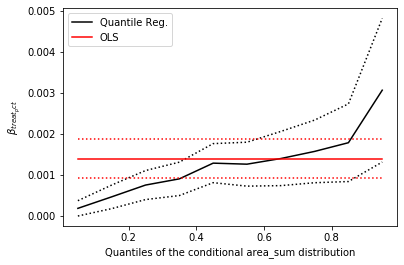

In [31]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{treat_pct}$')
plt.xlabel('Quantiles of the conditional area_sum distribution')
plt.legend()
plt.show()